## Setting the Colab with Food Recognition Dataset


In [ ]:
from google.colab import drive 

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/My Drive/Food Recognition project

/content/drive/My Drive/Food Recognition project


In [ ]:
# !unzip val-v0.4.tar.gz -d val

In [ ]:
# !unzip val-v0.4.tar.gz -d val

In [ ]:
ls

'linknet model with cross entropy'/       model_plot.png
'linknet model with dice loss'/           train/
'linknet model with focal loss'/          val/
'linknet model with squared dice loss'/


In [ ]:
%pip install -U --pre segmentation-models

     |████████████████████████████████| 51kB 5.8MB/s 


### Importing Required Libraries

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
import cv2
import skimage.io as io
from pycocotools.coco import COCO
import os
#Keras (tensorflow)
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add
from keras.layers.core import Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.activations import softmax
from typing import Callable, Union
#Segmentation_model 
import segmentation_models as sm

Segmentation Models: using `keras` framework.


### Loading the data 

In [ ]:
file_path = "/content/drive/MyDrive/Food Recognition project"
coco_train = COCO(file_path + '/train/annotations.json')
coco_val = COCO(file_path + '/val/annotations.json')

loading annotations into memory...
Done (t=2.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


### Exploring the Data and Segmentation Masks

In [ ]:
def plot_image(image_id):
    #read the image
    img = coco_train.loadImgs(image_id)[0]
    image = mpimg.imread(file_path + '/train/images/' + img['file_name'])
    
    #display image
    img_plot = plt.imshow(image)
    
    #loading image id
    annotations = coco_train.loadAnns(coco_train.getAnnIds(imgIds=image_id))

    for i in range(len(annotations)):
        #different color for different annotations
        colors = ['b', 'c', 'r', 'g', 'm', 'y', 'k'][i]
        ann = annotations[i]

        #plotting segmentation
        for seg in ann['segmentation']:
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.4)
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.8)
  
    #show results
    plt.show()

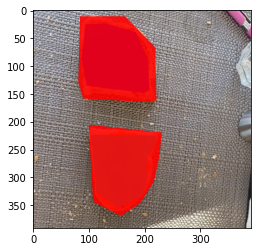

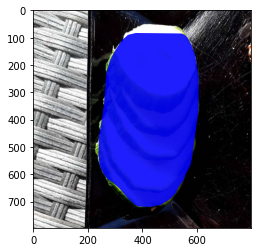

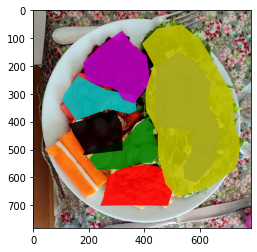

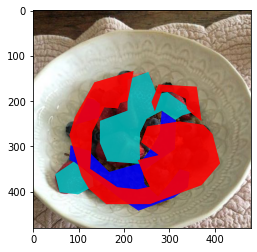

In [ ]:
#plotting random 
np.random.seed(0)
img_num = []
rand = np.random.randint(0, len(coco_train.getImgIds()), 4)
for i in rand:
    img_num.append(coco_train.getImgIds()[i])
for ids in img_num:
    plot_image(ids)

## Preprocessing the Dataset

Sorting the category ids by popularity

In [ ]:
def get_ordered_ids():
    catIds_raw = coco_train.getCatIds()
    catIds = []
    for cat in catIds_raw:
          catIds.append([len(coco_train.getImgIds(catIds=cat)), cat])
    catIds.sort()
    cat_ids = [cat_num[1] for cat_num in catIds ]
    return cat_ids

## display COCO categories

In [ ]:
categories = coco_train.loadCats(get_ordered_ids())
classes=[cat['name'] for cat in categories]
number_of_classes = len(classes)
print('COCO categories: ', number_of_classes)
print(classes)

COCO categories:  273
['veggie-burger', 'falafel-balls', 'bread-pita', 'rusk-wholemeal', 'frying-sausage', 'applesauce-unsweetened-canned', 'hazelnut', 'tea-peppermint', 'sauce-mushroom', 'sauce-soya', 'greek-yaourt-yahourt-yogourt-ou-yoghourt', 'green-bean-steamed-without-addition-of-salt', 'alfa-sprouts', 'beans-kidney', 'dates', 'focaccia', 'chocolate-cookies', 'tea-verveine', 'beef-sirloin-steak', 'beef-cut-into-stripes-only-meat', 'fruit-coulis', 'pizza-with-ham-baked', 'vegetable-mix-peas-and-carrots', 'cream', 'rice-whole-grain', 'artichoke', 'sesame-seeds', 'juice-apple', 'greek-salad', 'plums', 'dried-raisins', 'kefir-drink', 'veal-sausage', 'meat-terrine-pata-c', 'ice-tea', 'ham-croissant', 'soup-of-lentils-dahl-dhal', 'beetroot-raw', 'brioche', 'butter-spread-puree-almond', 'crunch-ma1-4esli', 'brownie', 'corn-crisps', 'mixed-seeds', 'bread-rye', 'bacon-cooking', 'pumpkin', 'flakes-oat', 'bread-5-grain', 'bread-fruit', 'rosti', 'pasta-noodles', 'hazelnut-chocolate-spread-nut

### Filtering the Dataset

In [ ]:
def filterDataset(folder, mode, classes=None):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}/annotations.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []

    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
      imgIds = coco.getImgIds()
      images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

## Function to create the masks

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        #Assign to the pixel the value of the class
        pixel_value = classes.index(className)+1
        #The annToMask method returns a binary mask. 
        #Multipling the mask of that class by the pixel_value we assign that value to each of the pixels  
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        #With np.maximum we join all the masks of different classes into a single one
        #The classes are sorted by popularity in descending order, so the mask of the most popular classes will prevail on the others
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

def getBinaryMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    n_classes = len(classes) + 1
    train_mask = np.zeros((input_image_size[0], input_image_size[1], n_classes))
    for i in range(len(anns)):
        #Get the index of the class
        className = getClassName(anns[i]['category_id'], cats)
        class_index = classes.index(className) + 1

        #If the index of the class is equal to the index iterating through the annotation add the
        #binary mask to the array
        
        new_mask = cv2.resize(coco.annToMask(anns[i]), input_image_size)
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0
        train_mask[:,:,class_index] = new_mask

    #Adding background mask into the training mask in position 0
    food_mask = np.argmax(train_mask, axis=2)
    background_mask = (np.logical_not(food_mask)).astype(int)
    train_mask[:,:,0] = background_mask
    
    return train_mask

##Data Generator

In [ ]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size, batch_size, mode, mask_type):
    
    img_folder = '{}/{}/images'.format(folder, mode)
    dataset_size = len(images)
    #catIds = get_category_ids()
    catIds = coco.getCatIds(catNms=classes)
    n_classes = len(classes) + 1
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        #mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], n_classes)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, classes, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

##Filtering the dataset and defining the generators

### 16 Categories

In [ ]:
classes = ['pasta-spaghetti','tomato-sauce','egg', 'bread-white', 'water','cheese','carrot','banana','tomato','wine-red','almonds','mandarine','sushi','biscuits','potatoes-steamed','chips-french-fries']

In [ ]:
train_images, train_dataset_size, train_coco = filterDataset(file_path,'train',classes)

loading annotations into memory...
Done (t=2.32s)
creating index...
index created!


In [ ]:
val_images, val_dataset_size, val_coco = filterDataset(file_path,'val',classes)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [ ]:
#train set
batch_size = 8
input_image_size = (256,256)
mask_type = 'binary'

train_gen = dataGeneratorCoco(train_images, classes, train_coco, file_path,
                            input_image_size, batch_size, 'train', mask_type)

In [ ]:
#val set
batch_size = 8
input_image_size = (256,256)
mask_type = 'binary'

val_gen = dataGeneratorCoco(val_images, classes, val_coco, file_path,
                            input_image_size, batch_size, 'val', mask_type)

In [ ]:
print("The training set size is:", train_dataset_size)
print("The validation set size is:", val_dataset_size)

The training set size is: 6171
The validation set size is: 318


Display Binary Mask

In [ ]:
def display_binary_masks(mask):
  
  n_classes = len(classes) + 1
  plt.figure(figsize=(25, 5))
  display_classes = ['background'] + classes

  for i in range(n_classes):
      color = i + 1
      new_mask = mask[:,:,i]*color
      plt.subplot(2,9,i+1)
      plt.title(display_classes[i])
      plt.axis('off')
      plt.imshow(new_mask)

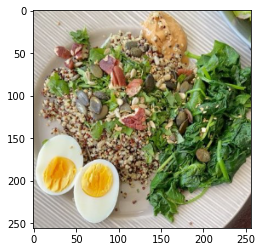

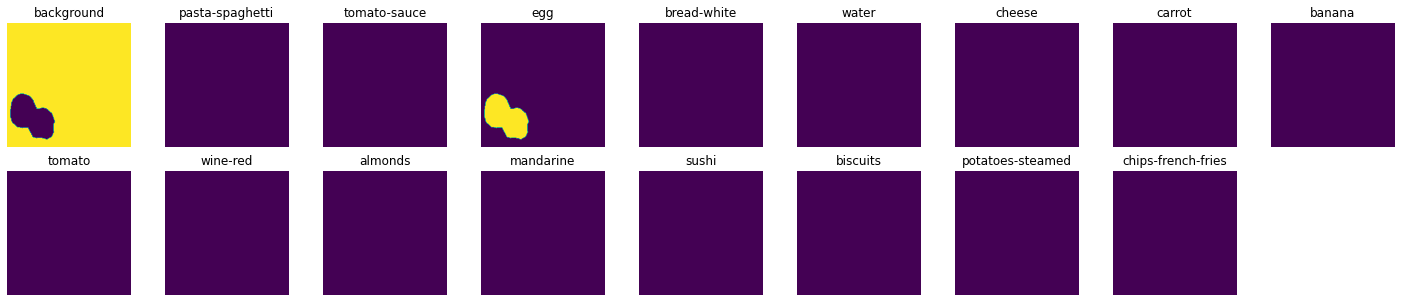

In [ ]:
image_id = 11
img_folder = '{}/{}/images'.format(file_path, 'train')
train_img = getImage(train_images[image_id], img_folder, input_image_size)
catIds = coco_train.getCatIds(catNms=classes)
mask = getBinaryMask(train_images[image_id], classes, coco_train, catIds, input_image_size)
plt.imshow(train_img)
display_binary_masks(mask)

##Generator for Visualizing 

In [ ]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)

    n_classes = len(classes) + 1
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)
        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                final_mask = np.zeros((input_image_size[0], input_image_size[1]))
                for i in range(1, n_classes):
                    color = i + 1
                    new_mask = mask[j][:,:,i]*color
                    final_mask = np.maximum(new_mask, final_mask)
                ax.imshow(final_mask);
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

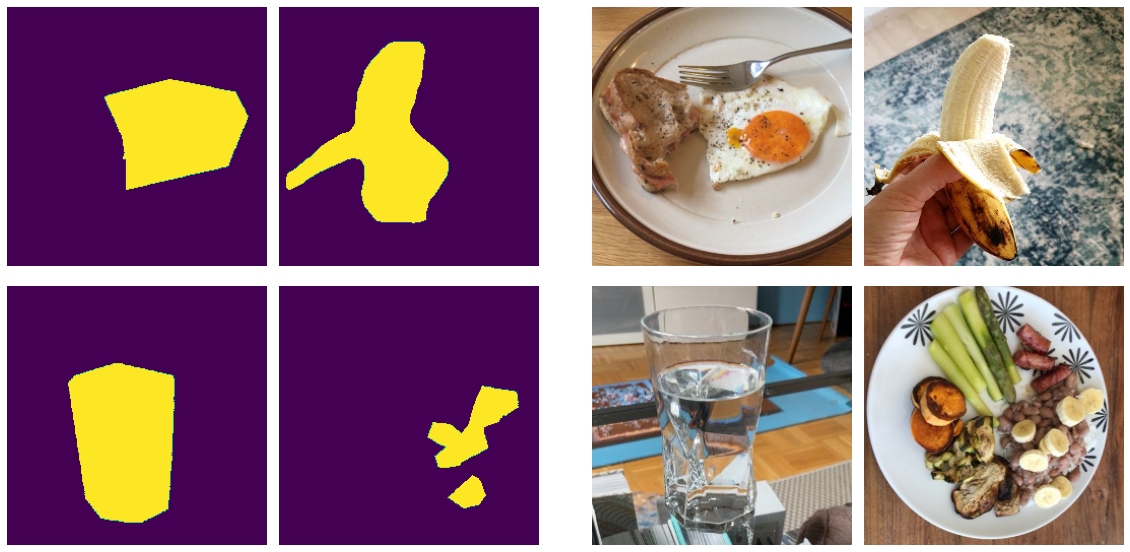

In [ ]:
visualizeGenerator(train_gen)

#Data Augmentation

In [ ]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    n_classes = len(classes)

    for img, mask in gen:

        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)

        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [ ]:
DataAugGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

In [ ]:
train_aug_gen = augmentationsGenerator(train_gen,DataAugGeneratorArgs)

In [ ]:
val_aug_gen = augmentationsGenerator(val_gen,DataAugGeneratorArgs)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 256, 256, 17) (17 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


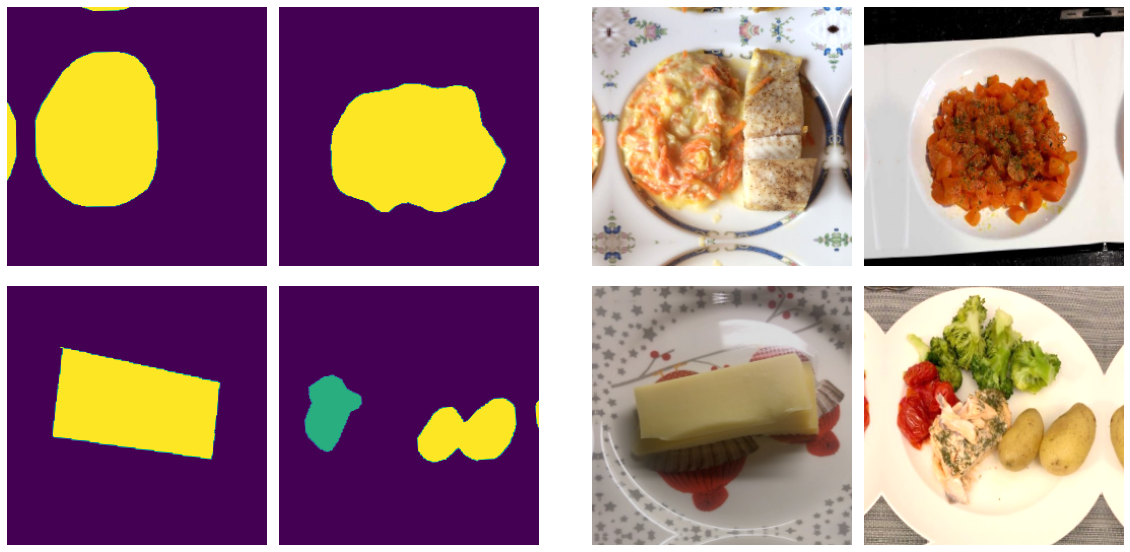

In [ ]:
visualizeGenerator(train_aug_gen)

## LinkNet Model

In [ ]:
def _link(input, residual):
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]
    link = input
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        link = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([link, residual])

In [ ]:
def encoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_1 = _link(input_tensor, x)

    x = BatchNormalization()(added_1)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_2 = _link(added_1, x)

    return added_2


def decoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(1, 1))(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(3, 3), padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(1, 1))(x)

    return x

In [ ]:
def LinkNet(input_shape=(256, 256, 3), classes=1):
    inputs = Input(shape=input_shape)

    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    encoder_1 = encoder_block(input_tensor=x, m=64, n=64)

    encoder_2 = encoder_block(input_tensor=encoder_1, m=64, n=128)

    encoder_3 = encoder_block(input_tensor=encoder_2, m=128, n=256)

    encoder_4 = encoder_block(input_tensor=encoder_3, m=256, n=512)

    decoder_4 = decoder_block(input_tensor=encoder_4, m=512, n=256)

    decoder_3_in = add([decoder_4, encoder_3])
    decoder_3_in = Activation('relu')(decoder_3_in)

    decoder_3 = decoder_block(input_tensor=decoder_3_in, m=256, n=128)

    decoder_2_in = add([decoder_3, encoder_2])
    decoder_2_in = Activation('relu')(decoder_2_in)

    decoder_2 = decoder_block(input_tensor=decoder_2_in, m=128, n=64)

    decoder_1_in = add([decoder_2, encoder_1])
    decoder_1_in = Activation('relu')(decoder_1_in)

    decoder_1 = decoder_block(input_tensor=decoder_1_in, m=64, n=64)

    x = UpSampling2D((2, 2))(decoder_1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=classes, activation="softmax" ,kernel_size=(2, 2), padding="same")(x)

    model = Model(inputs=inputs, outputs=x)

    return model

In [ ]:
number_of_classes = len(classes)+1
model = LinkNet(input_shape=(256, 256, 3), classes=number_of_classes)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 3)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 125, 64) 9472        activation[0][0]                 
______________________________________________________________________________________________

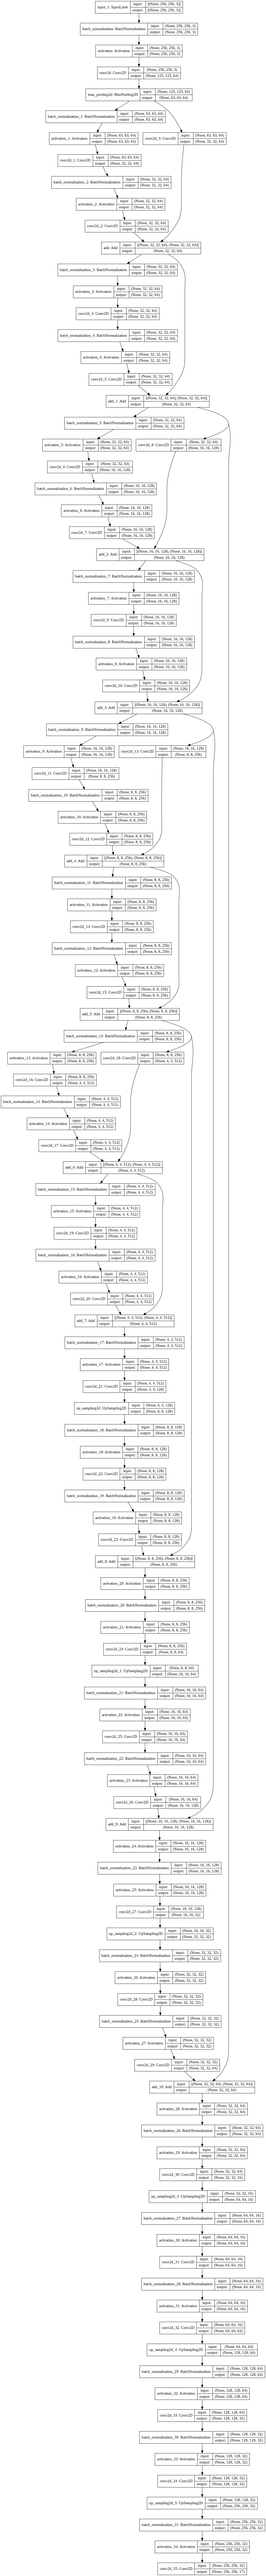

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Extracting Class weights

In [ ]:
# #Piece of code used to calculate the weights 
# pix_per_class = [0] * number_of_classes
# for i in range(len(train_images)):
#  mask = getNormalMask(train_images[i], classes, coco_train, catIds, input_image_size)
#  for x in mask:
#    for y in x:
#      pix_per_class[int(y)] += 1 
# print(pix_per_class)

# class_weights = [0] * number_of_classes
# total_pixels = 0
# for i in pix_per_class:
#  total_pixels = total_pixels + i

# for i in range(len(class_weights)):
#  weight = round(total_pixels / (number_of_classes * pix_per_class[i]), 3)
#  class_weights[i] = weight
# print(class_weights)

[319850298, 847098, 696840, 8777775, 1056672, 28298179, 3429373, 8215727, 4847370, 8241755, 5183185, 1834857, 2219971, 1091282, 1509297, 649968, 4134065]
[0.074, 27.838, 33.84, 2.686, 22.317, 0.833, 6.876, 2.87, 4.865, 2.861, 4.55, 12.852, 10.622, 21.609, 15.624, 36.281, 5.704]


### Class Weights

In [ ]:
class_weights = [0.074, 27.838, 33.84, 2.686, 22.317, 0.833, 6.876, 2.87, 4.865, 2.861, 4.55, 12.852, 10.622, 21.609, 15.624, 36.281, 5.704]

### Metrics

In [ ]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5) ]

## Model-1 with Multiclass-Weighted Cross Entropy

### Defining Multi-Weighted Cross Entropy

In [ ]:
def multiclass_weighted_cross_entropy(class_weights: list, is_logits: bool = False) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Multi-class weighted cross entropy.
        WCE(p, p̂) = −Σp*log(p̂)*class_weights
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Weight coefficients (list of floats)
    :param is_logits: If y_pred are logits (bool)
    :return: Weighted cross entropy loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the weighted cross entropy.
        :param y_true: Ground truth (tf.Tensor, shape=(None, None, None, None))
        :param y_pred: Predictions (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted cross entropy (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        assert len(class_weights) == y_pred.shape[-1], f"Number of class_weights ({len(class_weights)}) needs to be the same as number " \
                                                 f"of classes ({y_pred.shape[-1]})"

        if is_logits:
            y_pred = softmax(y_pred, axis=-1)

        y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())  # To avoid unwanted behaviour in K.log(y_pred)

        # p * log(p̂) * class_weights
        wce_loss = y_true * K.log(y_pred) * class_weights

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(wce_loss))
        wce_loss = K.mean(wce_loss, axis=axis_to_reduce)

        return -wce_loss

    return loss

### Compling the Model

In [ ]:
#optimizer
optimizer = 'adam'

#loss_function
lossFn = multiclass_weighted_cross_entropy(class_weights, is_logits = True)

model.compile(loss = lossFn, optimizer = optimizer, metrics=['accuracy',metrics])

### Training the Model

In [ ]:
#Number of Epochs
n_epochs = 15

#Steps per Epochs Training and Validation
steps_per_epoch = train_dataset_size // batch_size 
validation_steps = val_dataset_size // batch_size

filepath = file_path + '/linknet model with cross entropy/model_epoch{epoch:02d}_with_mw_crossentropy_loss.hdf5'

#Define the callbacks
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
]

#Start the training process
result = model.fit(x = train_aug_gen,
                validation_data = val_aug_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                callbacks = callbacks,
                epochs = n_epochs,
                verbose = True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 256, 256, 17) (17 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
771/771 [==============================] - 3772s 5s/step - loss: 0.1928 - accuracy: 0.4604 - iou_score: 0.4980 - f1-score: 0.5107 - val_loss: 0.1455 - val_accuracy: 0.4442 - val_iou_score: 0.4894 - val_f1-score: 0.5123

Epoch 00001: val_loss improved from inf to 0.14555, saving model to /content/drive/MyDrive/Food Recognition project/linknet model with cross entropy/model_epoch01_with_mw_crossentropy_loss.hdf5
Epoch 2/15
771/771 [==============================] - 650s 844ms/step - loss: 0.1329 - accuracy: 0.5496 - iou_score: 0.4897 - f1-score: 0.5131 - val_loss: 0.1331 - val_accuracy: 0.5725 - val_iou_score: 0.4498 - val_f1-score: 0.4721

Epoch 00002: val_loss improved from 0.14555 to 0.13309, saving model to /content/drive/MyDrive/Food Recognition project/linknet model with cross entropy/model_epoch02_with_mw_crossentropy_loss.hdf5
Epoch 3/15
771/771 [==============================] - 648s 841ms/step - loss: 0.1332 - accuracy: 0.5488 - iou_score: 0.4765 - f1-score: 0.5007 -

Plotting Training Accuracy vs Validation Accuracy & Training Loss vs Validation Loss

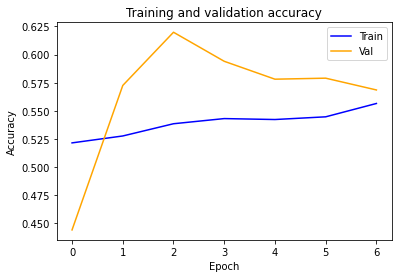

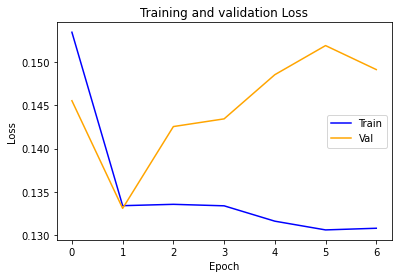

In [ ]:
 def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(acc))
    
    plt.title("Training and validation accuracy")
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
plot_history(result)

Plotting Training IOU score vs Validation IOU score & Training Loss vs Validation Loss




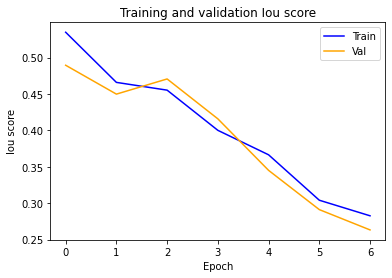

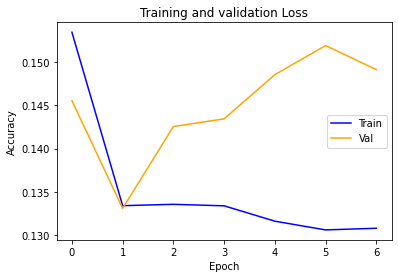

In [ ]:
def plot_history(history):
    
    iou = result.history['iou_score']
    val_iou = result.history['val_iou_score']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(iou))
    
    plt.title("Training and validation Iou score")
    plt.plot(epochs, iou, color='blue', label='Train')
    plt.plot(epochs, val_iou, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Iou score')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
plot_history(result)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
#Plots all the masks predicted by the model
def plot_predicted_masks(pred_mask):
  plt.figure(figsize=(25, 5))
  display_classes = ['background'] + classes
  for i in range(number_of_classes):
    new_mask = pred_mask[:,:,:,i]
    new_mask[new_mask >= 0.5] = 1
    new_mask[new_mask < 0.5] = 0
    plt.subplot(2,9,i+1)
    plt.title(display_classes[i])
    plt.axis('off')
    plt.imshow(new_mask.reshape(input_image_size[0], input_image_size[1]))

#Plot true mask
def plot_true_mask(true_mask):
  final_mask = np.zeros((input_image_size[0], input_image_size[1]))
  for i in range(1,number_of_classes):
    new_mask = true_mask[:,:,i]
    final_mask = np.maximum(new_mask, final_mask)
  return final_mask.reshape(input_image_size[0], input_image_size[1],1)

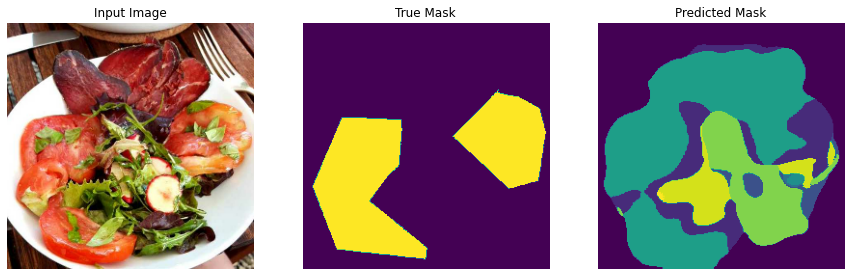

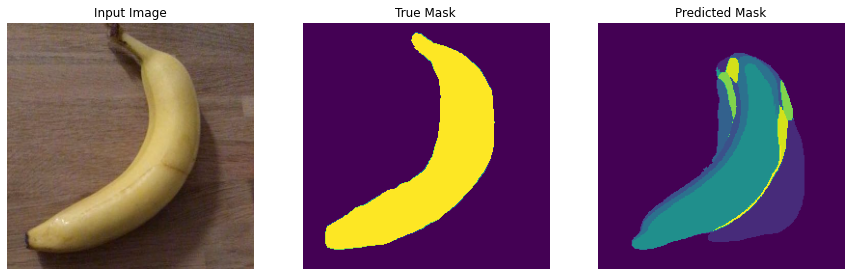

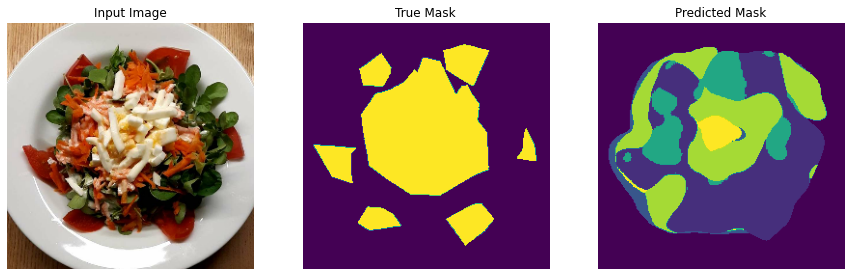

In [ ]:
#Plotting a few random images of the validations set
val_images_ids = []
for className in classes:
    # get all images containing given categories
    catIds = coco_val.getCatIds(catNms=className)
    imgIds = coco_val.getImgIds(catIds=catIds)
    for i in imgIds:
        val_images_ids.append(i)

num_image_to_plot = 3
rand = np.random.randint(0, len(val_images), num_image_to_plot)

X = np.zeros((num_image_to_plot, input_image_size[0], input_image_size[1], 3))

ids = [] #store here selected image ids selected in a random way 
j = 0
for i in rand:
  ids.append(val_images_ids[i])
  img = coco_val.loadImgs(val_images_ids[i])[0]
  image = tf.io.read_file(file_path+ '/val/images/' + img['file_name'])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, input_image_size)
  X[j] = image
  X[j] = X[j]/255.0
  j+=1
  

#Select images in order to get the true mask
images = []
for i in range(num_image_to_plot):
  for j in range(len(val_images)):
    if val_images[j]['id'] == ids[i]:
      images.append(val_images[j])

for i in range(len(X)):
  pred_mask = model.predict(X[i].reshape(1, input_image_size[0], input_image_size[1], 3))
  catIds = coco_val.getCatIds(catNms=classes)
  true_mask = getBinaryMask(images[i], classes, coco_val, catIds, input_image_size)
  display([X[i], plot_true_mask(true_mask), create_mask(pred_mask)])

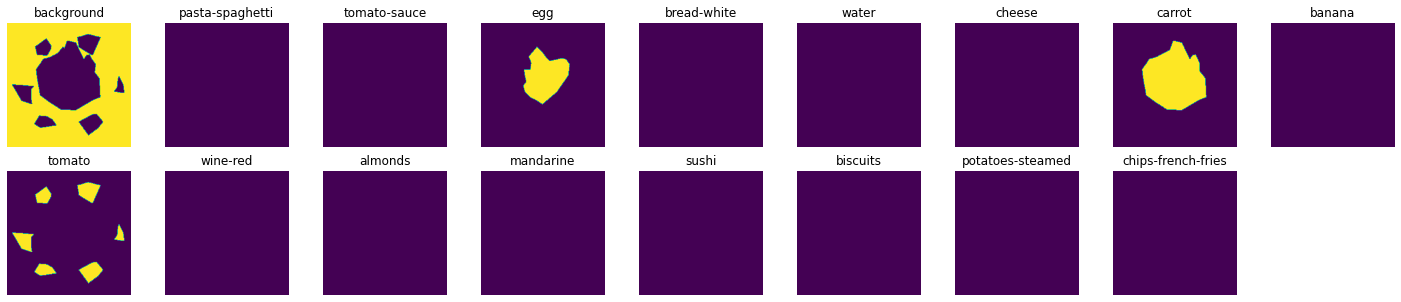

In [ ]:
#TRUE BINARY MASKS
display_binary_masks(true_mask)

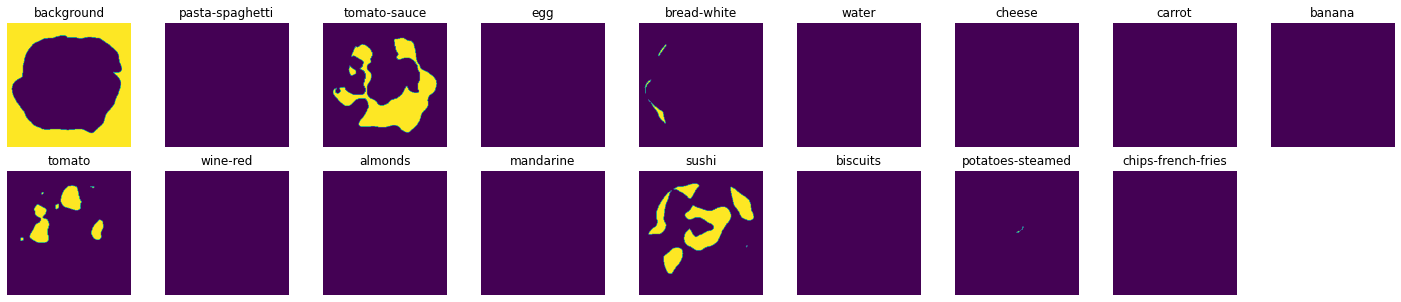

In [ ]:
#PREDICTED BINARY MASK
plot_predicted_masks(pred_mask)

## Model Evaluation

In [ ]:
def compute_metrics_single_image(true_mask, pred_mask):
  pred_mask[pred_mask >= 0.5] = 1
  pred_mask[pred_mask < 0.5] = 0
  #Using the IoU metric of the segmentation_models library
  iou_metric = sm.base.functional.iou_score(true_mask, pred_mask, backend = K)
  iou = np.round(iou_metric, decimals=2)
  
  true_mask = true_mask.reshape(1, input_image_size[0], input_image_size[1], number_of_classes)
  precision_metric = tf.keras.metrics.Precision()
  recall_metric = tf.keras.metrics.Recall()

  precision_metric.update_state(true_mask, pred_mask)
  precision = np.round(precision_metric.result(), decimals=2)
  
  recall_metric.update_state(true_mask, pred_mask)
  recall = np.round(recall_metric.result(), decimals=2)

  return iou, precision, recall

In [ ]:
iou_scores = []
precision_scores = []
recall_scores = []

def evaluation(model, data_gen):
  for i in range(val_dataset_size):
    img, true_mask = next(data_gen)
    pred_mask = model.predict(img)
    iou, precision, recall = compute_metrics_single_image(true_mask,pred_mask)
    iou_scores.append(iou)
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
evaluation_gen = dataGeneratorCoco(val_images, classes, coco_val, file_path, input_image_size, 1, 'val', mask_type)
evaluation(model, evaluation_gen)

In [ ]:
average_iou = np.mean(iou_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

In [ ]:
print(f"Mean IoU = {average_iou:.2f}, precision={average_precision:.2f}, recall = {average_recall:.2f}")

Mean IoU = 0.63, precision=0.62, recall = 0.56


## Model-2 with Multiclass-Weighted Dice Loss





### Defining Multi weighted Dice Loss

In [ ]:
def multiclass_weighted_dice_loss(class_weights: Union[list, np.ndarray, tf.Tensor]) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Weighted Dice loss.
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Class weight coefficients (Union[list, np.ndarray, tf.Tensor], len=<N_CLASSES>)
    :return: Weighted Dice loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute weighted Dice loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted Dice loss (tf.Tensor, shape=(None,))
        """
        axis_to_reduce = range(1, K.ndim(y_pred))  # Reduce all axis but first (batch)
        numerator = y_true * y_pred * class_weights  # Broadcasting
        numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

        denominator = (y_true + y_pred) * class_weights # Broadcasting
        denominator = K.sum(denominator, axis=axis_to_reduce)

        return 1 - numerator / denominator

    return loss

### Compling the Model

In [ ]:
#optimizer
optimizer = 'adam'

##loss function
lossFn = multiclass_weighted_dice_loss(class_weights=class_weights)

#Compile your model first
model.compile(loss = lossFn, optimizer = optimizer, metrics=['accuracy',metrics])

## Training the Model

In [ ]:
#Number of Epochs
n_epochs = 15

#Steps per Epochs Training and Validation
steps_per_epoch = train_dataset_size // batch_size 
validation_steps = val_dataset_size // batch_size

filepath = file_path + '/linknet model with dice loss/model_epoch{epoch:02d}_with_multi_weighted_dice_loss.hdf5'

#Define the callbacks
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
]

#Start the training process
result = model.fit(x = train_aug_gen,
                validation_data = val_aug_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                callbacks = callbacks,
                epochs = n_epochs,
                verbose = True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 256, 256, 17) (17 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
771/771 [==============================] - 3096s 4s/step - loss: 0.8134 - accuracy: 0.6817 - iou_score: 0.6159 - f1-score: 0.6272 - val_loss: 0.6430 - val_accuracy: 0.8345 - val_iou_score: 0.6544 - val_f1-score: 0.6665

Epoch 00001: val_loss improved from inf to 0.64303, saving model to /content/drive/MyDrive/Food Recognition project/linknet model with dice loss/model_epoch01_with_multi_weighted_dice_loss.hdf5
Epoch 2/15
771/771 [==============================] - 761s 988ms/step - loss: 0.6364 - accuracy: 0.8407 - iou_score: 0.6765 - f1-score: 0.6885 - val_loss: 0.6241 - val_accuracy: 0.8424 - val_iou_score: 0.6598 - val_f1-score: 0.6725

Epoch 00002: val_loss improved from 0.64303 to 0.62412, saving model to /content/drive/MyDrive/Food Recognition project/linknet model with dice loss/model_epoch02_with_multi_weighted_dice_loss.hdf5
Epoch 3/15
771/771 [==============================] - 745s 967ms/step - loss: 0.6359 - accuracy: 0.8446 - iou_score: 0.6709 - f1-score: 0.6830 -

Plotting Training Accuracy vs Validation Accuracy & Training Loss vs Validation Loss

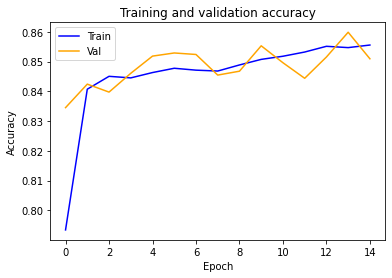

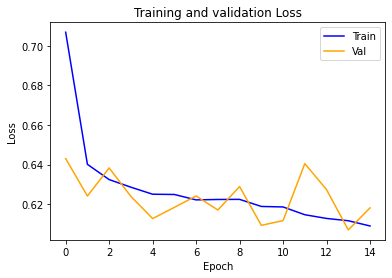

In [ ]:
 def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(acc))
    
    plt.title("Training and validation accuracy")
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
plot_history(result)

Plotting Training IOU score vs Validation IOU score & Training Loss vs Validation Loss




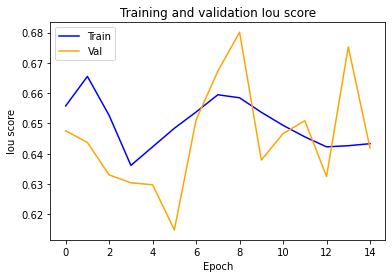

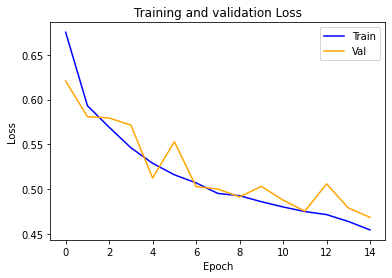

In [ ]:
def plot_history(history):
    
    iou = history.history['iou_score']
    val_iou = history.history['val_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(iou))
    
    plt.title("Training and validation Iou score")
    plt.plot(epochs, iou, color='blue', label='Train')
    plt.plot(epochs, val_iou, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Iou score')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
plot_history(result)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
#Plots all the masks predicted by the model
def plot_predicted_masks(pred_mask):
  plt.figure(figsize=(25, 5))
  display_classes = ['background'] + classes
  for i in range(number_of_classes):
    new_mask = pred_mask[:,:,:,i]
    new_mask[new_mask >= 0.5] = 1
    new_mask[new_mask < 0.5] = 0
    plt.subplot(2,9,i+1)
    plt.title(display_classes[i])
    plt.axis('off')
    plt.imshow(new_mask.reshape(input_image_size[0], input_image_size[1]))

#Plot true mask
def plot_true_mask(true_mask):
  final_mask = np.zeros((input_image_size[0], input_image_size[1]))
  for i in range(1,number_of_classes):
    new_mask = true_mask[:,:,i]
    final_mask = np.maximum(new_mask, final_mask)
  return final_mask.reshape(input_image_size[0], input_image_size[1],1)

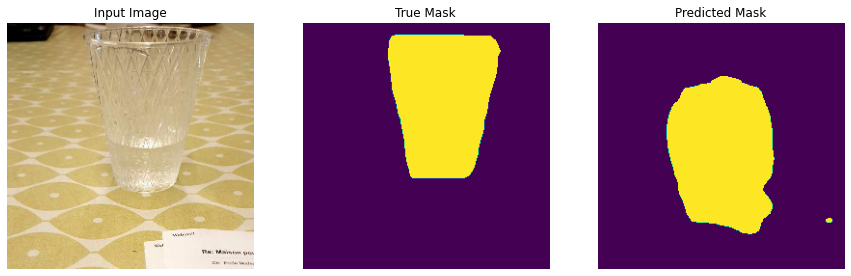

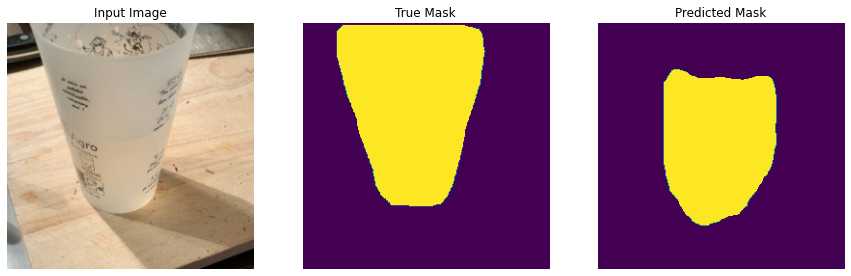

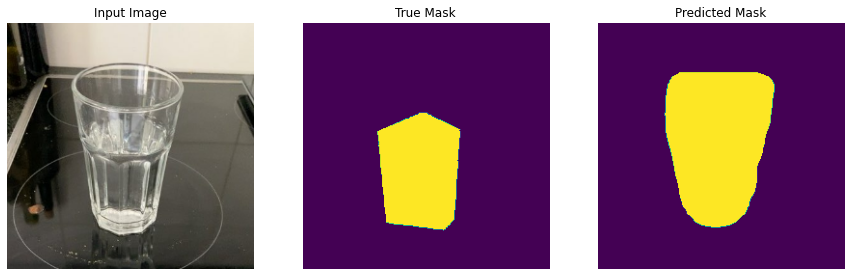

In [ ]:
#Plotting a few random images of the validations set

val_images_ids = []
for className in classes:
    # get all images containing given categories
    catIds = coco_val.getCatIds(catNms=className)
    imgIds = coco_val.getImgIds(catIds=catIds)
    for i in imgIds:
        val_images_ids.append(i)

num_image_to_plot = 3
rand = np.random.randint(0, len(val_images), num_image_to_plot)

X = np.zeros((num_image_to_plot, input_image_size[0], input_image_size[1], 3))

ids = [] #store here selected image ids selected in a random way 
j = 0
for i in rand:
  ids.append(val_images_ids[i])
  img = coco_val.loadImgs(val_images_ids[i])[0]
  image = tf.io.read_file(file_path + '/val/images/' + img['file_name'])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, input_image_size)
  X[j] = image
  X[j] = X[j]/255.0
  j+=1
  

#Select images in order to get the true mask
images = []
for i in range(num_image_to_plot):
  for j in range(len(val_images)):
    if val_images[j]['id'] == ids[i]:
      images.append(val_images[j])

for i in range(len(X)):
  pred_mask = model.predict(X[i].reshape(1, input_image_size[0], input_image_size[1], 3))
  catIds = coco_val.getCatIds(catNms=classes)
  true_mask = getBinaryMask(images[i], classes, coco_val, catIds, input_image_size)
  display([X[i], plot_true_mask(true_mask), create_mask(pred_mask)])


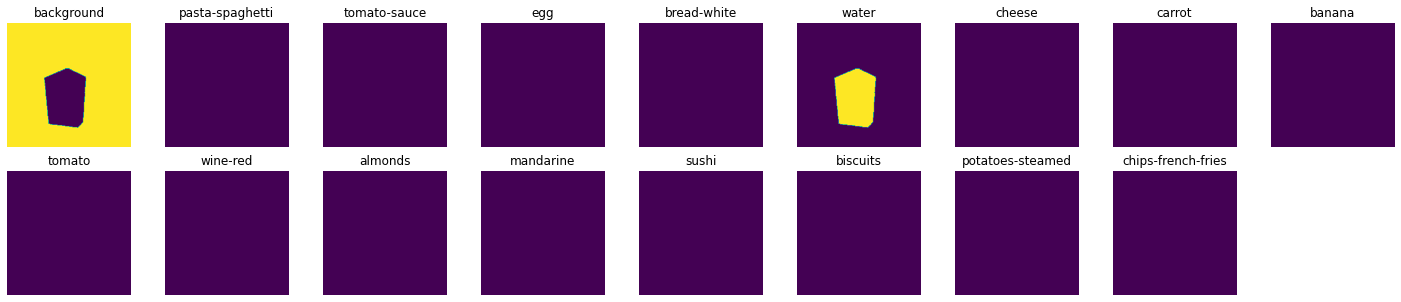

In [ ]:
#TRUE BINARY MASKS
display_binary_masks(true_mask)

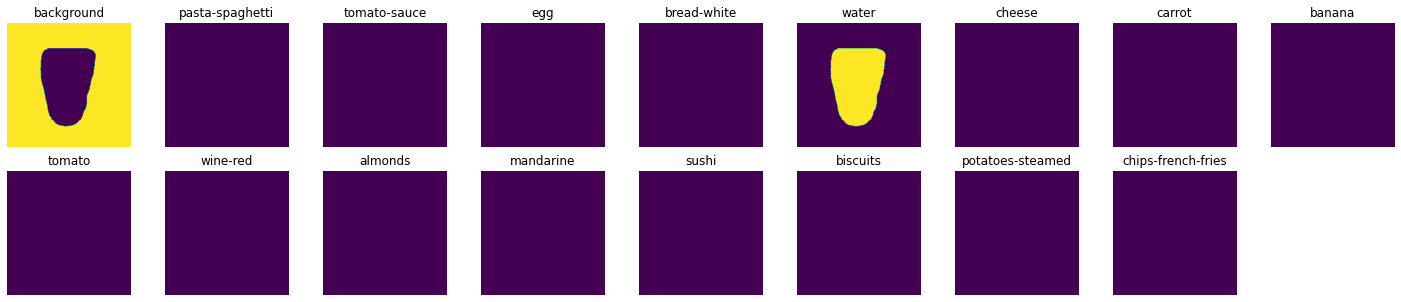

In [ ]:
#PREDICTED BINARY MASK
plot_predicted_masks(pred_mask)

### Model Evaluations

In [ ]:
def compute_metrics_single_image(true_mask, pred_mask):
  pred_mask[pred_mask >= 0.5] = 1
  pred_mask[pred_mask < 0.5] = 0
  #Using the IoU metric of the segmentation_models library
  iou_metric = sm.base.functional.iou_score(true_mask, pred_mask, backend = K)
  iou = np.round(iou_metric, decimals=2)
  
  true_mask = true_mask.reshape(1, input_image_size[0], input_image_size[1], number_of_classes)
  precision_metric = tf.keras.metrics.Precision()
  recall_metric = tf.keras.metrics.Recall()

  precision_metric.update_state(true_mask, pred_mask)
  precision = np.round(precision_metric.result(), decimals=2)
  
  recall_metric.update_state(true_mask, pred_mask)
  recall = np.round(recall_metric.result(), decimals=2)

  return iou, precision, recall

In [ ]:
iou_scores = []
precision_scores = []
recall_scores = []

def evaluation(model, data_gen):
  for i in range(val_dataset_size):
    img, true_mask = next(data_gen)
    pred_mask = model.predict(img)
    iou, precision, recall = compute_metrics_single_image(true_mask,pred_mask)
    iou_scores.append(iou)
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
evaluation_gen = dataGeneratorCoco(val_images, classes, coco_val, file_path, input_image_size, 1, 'val', mask_type)
evaluation(model, evaluation_gen)

In [ ]:
average_iou = np.mean(iou_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

In [ ]:
print(f"Mean IoU = {average_iou:.2f}, precision={average_precision:.2f}, recall = {average_recall:.2f}")

Mean IoU = 0.92, precision=0.83, recall = 0.82


# *Model-3 with Multiclass-Weighted Squared Dice Loss*

##Multiclass-Weighted squared Dice Loss Function

In [ ]:
def multiclass_weighted_squared_dice_loss(class_weights: Union[list, np.ndarray, tf.Tensor]) -> Callable[[tf.Tensor, tf.Tensor],
                                                                                                   tf.Tensor]:
    """
    Weighted squared Dice loss.
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Class weight coefficients (Union[list, np.ndarray, tf.Tensor], len=<N_CLASSES>)
    :return: Weighted squared Dice loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute weighted squared Dice loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted squared Dice loss (tf.Tensor, shape=(None,))
        """
        axis_to_reduce = range(1, K.ndim(y_pred))  # Reduce all axis but first (batch)
        numerator = y_true * y_pred * class_weights  # Broadcasting
        numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

        denominator = (y_true**2 + y_pred**2) * class_weights  # Broadcasting
        denominator = K.sum(denominator, axis=axis_to_reduce)

        return 1 - numerator / denominator

    return loss

### Compiling the Model

In [ ]:
#optimizer
optimizer = 'adam'

##loss function
lossFn = multiclass_weighted_squared_dice_loss(class_weights=class_weights)

#Compile your model first
model.compile(loss = lossFn, optimizer = optimizer, metrics=['accuracy',metrics])

### Training the Model

In [ ]:
#Number of Epochs
n_epochs = 15

#Steps per Epochs Training and Validation
steps_per_epoch = train_dataset_size // batch_size 
validation_steps = val_dataset_size // batch_size

filepath = file_path + '/linknet model with squared dice loss/model_epoch{epoch:02d}_with_multi_weighted_squared_dice_loss.hdf5'

#Define the callbacks
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
]

#Start the training process
result = model.fit(x = train_aug_gen,
                validation_data = val_aug_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                callbacks = callbacks,
                epochs = n_epochs,
                verbose = True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 256, 256, 17) (17 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
771/771 [==============================] - 781s 977ms/step - loss: 0.7695 - accuracy: 0.7052 - iou_score: 0.6187 - f1-score: 0.6302 - val_loss: 0.6207 - val_accuracy: 0.8291 - val_iou_score: 0.6476 - val_f1-score: 0.6624

Epoch 00001: val_loss improved from inf to 0.62070, saving model to /content/drive/MyDrive/Food Recognition project/linknet model with squared dice loss/model_epoch01_with_multi_weighted_squared_dice_loss.hdf5
Epoch 2/15
771/771 [==============================] - 745s 967ms/step - loss: 0.6049 - accuracy: 0.8334 - iou_score: 0.6659 - f1-score: 0.6791 - val_loss: 0.5809 - val_accuracy: 0.8450 - val_iou_score: 0.6437 - val_f1-score: 0.6578

Epoch 00002: val_loss improved from 0.62070 to 0.58085, saving model to /content/drive/MyDrive/Food Recognition project/linknet model with squared dice loss/model_epoch02_with_multi_weighted_squared_dice_loss.hdf5
Epoch 3/15
771/771 [==============================] - 740s 961ms/step - loss: 0.5749 - accuracy: 0.8361 - iou_

Plotting Training Accuracy vs Validation Accuracy & Training Loss vs Validation Loss

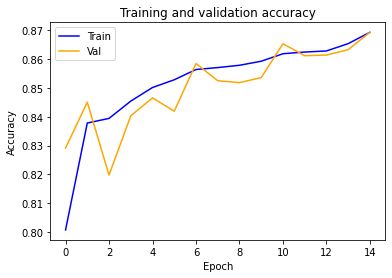

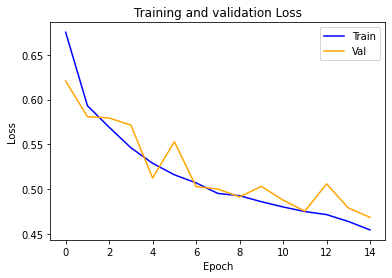

In [ ]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(acc))
    
    plt.title("Training and validation accuracy")
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
plot_history(result)

Plotting Training IOU score vs Validation IOU score & Training Loss vs Validation Loss




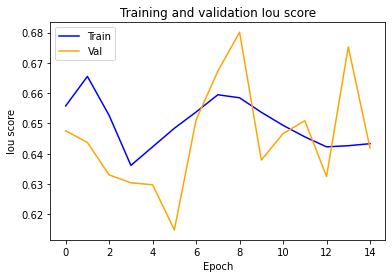

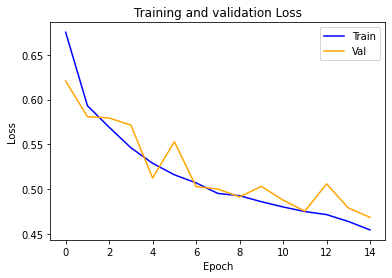

In [ ]:
def plot_history(history):
    
    iou = result.history['iou_score']
    val_iou = result.history['val_iou_score']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(iou))
    
    plt.title("Training and validation Iou score")
    plt.plot(epochs, iou, color='blue', label='Train')
    plt.plot(epochs, val_iou, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Iou score')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
plot_history(result)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
#Plots all the masks predicted by the model
def plot_predicted_masks(pred_mask):
  plt.figure(figsize=(25, 5))
  display_classes = ['background'] + classes
  for i in range(number_of_classes):
    new_mask = pred_mask[:,:,:,i]
    new_mask[new_mask >= 0.5] = 1
    new_mask[new_mask < 0.5] = 0
    plt.subplot(2,9,i+1)
    plt.title(display_classes[i])
    plt.axis('off')
    plt.imshow(new_mask.reshape(input_image_size[0], input_image_size[1]))

#Plot true mask
def plot_true_mask(true_mask):
  final_mask = np.zeros((input_image_size[0], input_image_size[1]))
  for i in range(1,number_of_classes):
    new_mask = true_mask[:,:,i]
    final_mask = np.maximum(new_mask, final_mask)
  return final_mask.reshape(input_image_size[0], input_image_size[1],1)

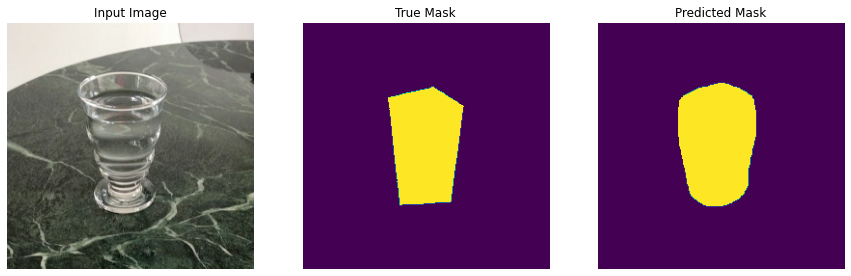

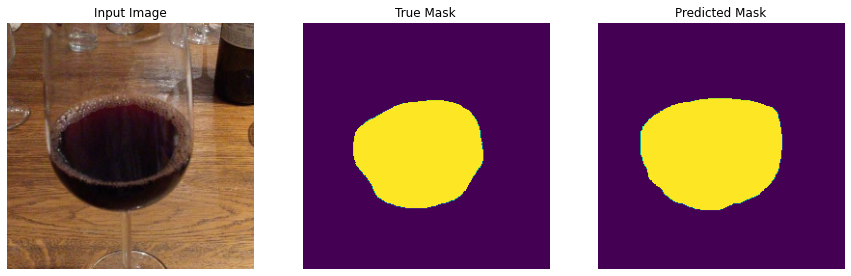

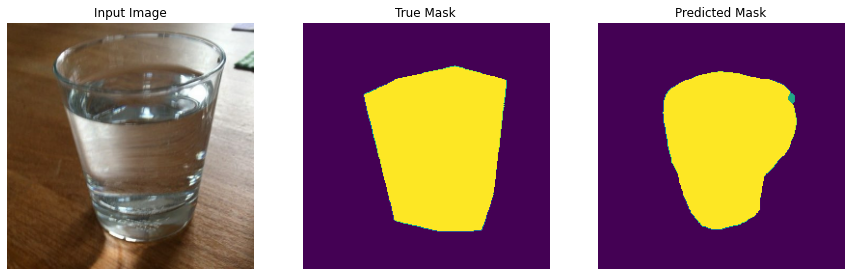

In [ ]:
#Plotting a few random images of the validations set
val_images_ids = []
for className in classes:
    # get all images containing given categories
    catIds = coco_val.getCatIds(catNms=className)
    imgIds = coco_val.getImgIds(catIds=catIds)
    for i in imgIds:
        val_images_ids.append(i)

num_image_to_plot = 3
rand = np.random.randint(0, len(val_images), num_image_to_plot)

X = np.zeros((num_image_to_plot, input_image_size[0], input_image_size[1], 3))

ids = [] #store here selected image ids selected in a random way 
j = 0
for i in rand:
  ids.append(val_images_ids[i])
  img = coco_val.loadImgs(val_images_ids[i])[0]
  image = tf.io.read_file(file_path+ '/val/images/' + img['file_name'])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, input_image_size)
  X[j] = image
  X[j] = X[j]/255.0
  j+=1
  

#Select images in order to get the true mask
images = []
for i in range(num_image_to_plot):
  for j in range(len(val_images)):
    if val_images[j]['id'] == ids[i]:
      images.append(val_images[j])

for i in range(len(X)):
  pred_mask = model.predict(X[i].reshape(1, input_image_size[0], input_image_size[1], 3))
  catIds = coco_val.getCatIds(catNms=classes)
  true_mask = getBinaryMask(images[i], classes, coco_val, catIds, input_image_size)
  display([X[i], plot_true_mask(true_mask), create_mask(pred_mask)])

### Model Evaluations

In [ ]:
def compute_metrics_single_image(true_mask, pred_mask):
  pred_mask[pred_mask >= 0.5] = 1
  pred_mask[pred_mask < 0.5] = 0
  #Using the IoU metric of the segmentation_models library
  iou_metric = sm.base.functional.iou_score(true_mask, pred_mask, backend = K)
  iou = np.round(iou_metric, decimals=2)
  
  true_mask = true_mask.reshape(1, input_image_size[0], input_image_size[1], number_of_classes)
  precision_metric = tf.keras.metrics.Precision()
  recall_metric = tf.keras.metrics.Recall()

  precision_metric.update_state(true_mask, pred_mask)
  precision = np.round(precision_metric.result(), decimals=2)
  
  recall_metric.update_state(true_mask, pred_mask)
  recall = np.round(recall_metric.result(), decimals=2)

  return iou, precision, recall

In [ ]:
iou_scores = []
precision_scores = []
recall_scores = []

def evaluation(model, data_gen):
  for i in range(val_dataset_size):
    img, true_mask = next(data_gen)
    pred_mask = model.predict(img)
    iou, precision, recall = compute_metrics_single_image(true_mask,pred_mask)
    iou_scores.append(iou)
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
evaluation_gen = dataGeneratorCoco(val_images, classes, coco_val, file_path, input_image_size, 1, 'val', mask_type)
evaluation(model, evaluation_gen)

In [ ]:
average_iou = np.mean(iou_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

In [ ]:
print(f"Mean IoU = {average_iou:.2f}, precision={average_precision:.2f}, recall = {average_recall:.2f}")

Mean IoU = 0.90, precision=0.87, recall = 0.84


# Comparision of Models 

#Model1

Loss function: Muliclass Cross Entropy Loss

Batch size: 8

Obtained Results:

**Mean IoU = 0.63, precision=0.62, recall = 0.56**


# Model 2

Loss Function: Multiclass Dice Loss

Batch size: 8 

Obtained Results: 

**Mean IoU = 0.92, precision=0.83, recall = 0.82**

# Model 3

Loss function: Muliclass Squared Dice Loss

Batch size: 8

Obtained Results:

**Mean IoU = 0.90, precision=0.87, recall = 0.84**

